# Natural Language Processing Course Project
### Politecnico di Milano, A.Y. 2024/2025

This notebook has been created for the Natural Language Processing course, held by Prof. Carman.

**Authors**:
* Matteo Figini
* Riccardo Figini
* Samuele Forner
* Caterina Motti
* Simone Zacchetti

The purpose of this notebook is to apply different NLP techniques to analyse the **RecipeNLG** dataset, you can find the dataset at the following [link](https://huggingface.co/datasets/mbien/recipe_nlg).

In [ ]:
# Import useful libraries
import numpy as np
import pandas as pd
import os
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import seaborn as sns
import joblib

# Preliminary analysis

In this section, we aim to perform a preliminary analysis of the dataset.
- Load and inspect the dataset: analyze which field are present, missing field or inconsistencies.
- Analyze the vocaboulary.
- Analyze recipe distribution.
- Analyze entities distribution.

### Load and inspect the dataset

In [ ]:
# Load the dataset from CSV file and show its head
df = pd.read_csv("/kaggle/input/recipenlg/dataset/full_dataset.csv")
df

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [ ]:
# Show the name of the columns
print("Columns:", df.columns.tolist())

Columns: ['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source', 'NER']


Since the first column has no name, we renamed it:

In [ ]:
df = df.rename(columns={'Unnamed: 0': 'id'})

In [ ]:
# Dataset length
print(f"In the dataset there are {len(df)} different recipes!")

In the dataset there are 2231142 different recipes!


As we can see, the dataset contains 2231142 entries in 7 columns:
- id (int): ID.
- title (str): title of the recipe.
- ingredients (list of str): ingredients.
- directions (list of str): instruction steps.
- link (str): URL link.
- source (ClassLabel): origin of each recipe record, with possible value {"Gathered", "Recipes1M"}:
    - "Gathered" (0): additional recipes gathered from multiple cooking web pages using automated scripts in a web scraping process.
    - "Recipes1M" (1): recipes from the "Recipe1M+" dataset.
- NER (list of str): NER food entities.

Now, we check for **inconsistencies** and remove them if needed.

In [ ]:
# Rows with missing values
rows_with_null = df.isnull().any(axis=1).sum()
print(f"There are {rows_with_null} rows with at least one null value.")
print(df.isnull().sum())

There are 1 rows with at least one null value.
id             0
title          1
ingredients    0
directions     0
link           0
source         0
NER            0
dtype: int64


The missing value is a title, which is not a critical field. However, we prefer to remove it.

In [ ]:
# Delete rows with at least one missing value
df.dropna()

,id,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [ ]:
# Find duplicates by title
duplicate_counts = df['title'].value_counts()
print("Duplication results by: ", duplicate_counts)

Duplication results by:  title
Chicken Casserole                      4099
Broccoli Casserole                     3985
Squash Casserole                       2508
Cheese Ball                            2426
Zucchini Bread                         2298
                                       ... 
House Slytherin Key Lime Bars             1
Cheesy Loaded Hash Browns Casserole       1
Low Carb Mexican Chicken                  1
Old Fashioned Cocoa                       1
Polpette in Spicy Tomato Sauce            1
Name: count, Length: 1312870, dtype: int64


Here we have lots of duplicates. However, they might represent different variations of the same recipe which could be useful for further analysis.

Since the dataset is really big (2M+ entries), we decided to make a random subsampling of it by retaining only 25% (around half million entries).

In [ ]:
# Randomly sample the dataset
df = df.sample(frac=0.25, random_state=42)

### Analyze vocaboulary

In [ ]:
# Import necessary libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import bigrams

# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Define a new column 'text' with directions as a string
df['text'] = df['directions'].apply(lambda x: ' '.join(ast.literal_eval(x)))
all_instructions_list = df['text'].tolist()

# Preprocess the text and tokenize it into words
full_text = ' '.join(all_instructions_list)
full_text = full_text.lower()
full_text = re.sub(r'[^a-zA-Z0-9\s]', '', full_text)
words = full_text.split()

# Remove stopwords and tokenize
stop_words = set(stopwords.words('english'))
words_nostopwords = [w for w in words if w not in stop_words]
tokens = [w for w in words_nostopwords]

# Generate bigrams and frequency distribution
bigram_list = list(bigrams(tokens))
bigram_fdist = FreqDist(bigram_list)

# Frequency distribution of words
fdist = FreqDist(words_nostopwords)

In [ ]:
# Vocabulary size
vocabulary_size = len(fdist)
print("Vocabulary size: ", vocabulary_size)

# Average number of unique words per recipe
unique_words_per_recipe = []

for directions in df['text']:
    directions = directions.lower()
    directions = re.sub(r'[^a-zA-Z0-9\s]', '', directions)  # remove punctuation
    tokens = directions.split()  # split into words
    tokens = [w for w in tokens if w not in stop_words]
    unique_words = set(tokens)
    unique_words_per_recipe.append(len(unique_words))

avg_unique_words_per_recipe = sum(unique_words_per_recipe) / len(unique_words_per_recipe)
print("Average number of unique words per recipe: ", avg_unique_words_per_recipe)

# Compute word length distribution
word_lengths = [len(word) for word in words_nostopwords]
avg_word_length = sum(word_lengths) / len(word_lengths)
min_word_length = min(word_lengths)
max_word_length = max(word_lengths)

print("Average word length: ", avg_word_length, " characters")
print("Minimum word length: ", min_word_length, " characters")
print("Maximum word length: ", max_word_length, " characters")

Vocabulary size:  112018
Average number of unique words per recipe:  43.36856787370067
Average word length:  5.285405950756063  characters
Minimum word length:  1  characters
Maximum word length:  262  characters


The high vocabulary size shows that the dataset is very rich and diverse, covering many ingredients, actions, and contextual descriptions.

However the average number of unique words in each recipe is quite small: this suggests that each recipe tends to use a fairly concise and domain-specific subset.

NB: the maximum word length (262 characters) is likely an outlier. We must investigate it further.

In [ ]:
# Find the longest words
def find_long_words_in_directions(df):
    long_words = []

    for directions in df['text']:
        # Extract words longer than 45 characters, since in English vocabulary the longest word has 45 characters
        long_words.extend([word for word in directions.split() if len(word) > 45])

    if long_words:
        print("Found ", len(long_words), " long words in the dataset (greater than 45 characters).")
        print("Printing the first 10 for brevity: \n")
        print(long_words[:10])
    else:
        print("No words longer than 45 characters found.")

find_long_words_in_directions(df)

Found  620  long words in the dataset (greater than 45 characters).
Printing the first 10 for brevity: 

['https://food52.com/blog/3601-how-to-temper-chocolate', 'http://www.discountqueens.com/homemade-dry-onion-soup-mix/.', 'http://www.bonappetit.com/recipes/2012/04/nonna-consuelos-bolognese-sauce#ixzz1s9eVVHNG', 'http://leitesculinaria.com/99229/recipes-cinnamon-granola-bars.html#o3BvUmhKMCExxhX8.99', '(http://www.ehow.com/how_4731920_temper-an-egg.html).', 'https://cookpad.com/en/recipes/156069-kimchi-and-egg-rice-bowl-and-oyako-don-with-tinned-yakitori-chicken', 'https://cookpad.com/en/recipes/151167-sweet-savory-pork-rice-bowl', 'http://www.kitchenriffs.com/2013/06/the-dark-and-stormy-cocktail.html.', 'http://alldayidreamaboutfood.com/2012/04/maple-pecan-scones-low-carb-and-gluten-free.html', 'http://www.lowcarbmaven.com/easyrecipe-print/10109-0']


Most of them are links, so we can keep them (also considering that they are not that frequent).

In [ ]:
# Create frequency distribution for bigrams
bigram_fdist = FreqDist(bigram_list)

# Display top 10 most common words
print("\nTop 10 most common words:")
for word, freq in fdist.most_common(10):
    print(f"{word}: {freq}")

# Display top 10 most common bigrams
print("\nTop 10 most common bigrams:")
for bigram, freq in bigram_fdist.most_common(10):
    print(f"{' '.join(bigram)}: {freq}")



Top 10 most common words:
add: 681360
minutes: 598142
heat: 396857
mix: 310106
cook: 277251
bowl: 275700
pan: 274190
stir: 272397
mixture: 272239
1: 265148

Top 10 most common bigrams:
salt pepper: 92694
preheat oven: 83194
5 minutes: 72573
10 minutes: 70488
set aside: 70229
medium heat: 62024
large bowl: 61419
30 minutes: 57096
olive oil: 52748
15 minutes: 52534


### Analyze recipes distribution
Since the recipes are the core of the dataset, it may be useful to analyse the length of each recipe to plot their distribution.

Recipes with very high or very low word counts might be outliers. Analyzing the distribution allows us to detect these outliers, which might skew our analysis. For instance, a recipe with only one word might be a mistake.

In [ ]:
# Define a new column to count the number of words in 'directions'
df['dir_word_count'] = df['directions'].apply(lambda x: len(' '.join(x).split()))

In [ ]:
# Retrieve the length and index of the longest and shortest recipe
max_words = df['dir_word_count'].max()
min_words = df['dir_word_count'].min()

max_words_idx = df['dir_word_count'].idxmax()
min_words_idx = df['dir_word_count'].idxmin()
print(f"Recipes' direction have between {min_words} and {max_words} words.")
print(f"The longest recipe has {max_words} words and it stands at location {max_words_idx}.")
#print(df['directions'].loc[max_words_idx])
print(df[['title','directions', 'dir_word_count']].loc[min_words_idx])

Recipes' direction have between 5 and 12375 words.
The longest recipe has 12375 words and it stands at location 1739457.
title             Seared Salmon, Carrot Tortellini, Red Pepper-C...
directions                                                    ["d"]
dir_word_count                                                    5
Name: 2119768, dtype: object


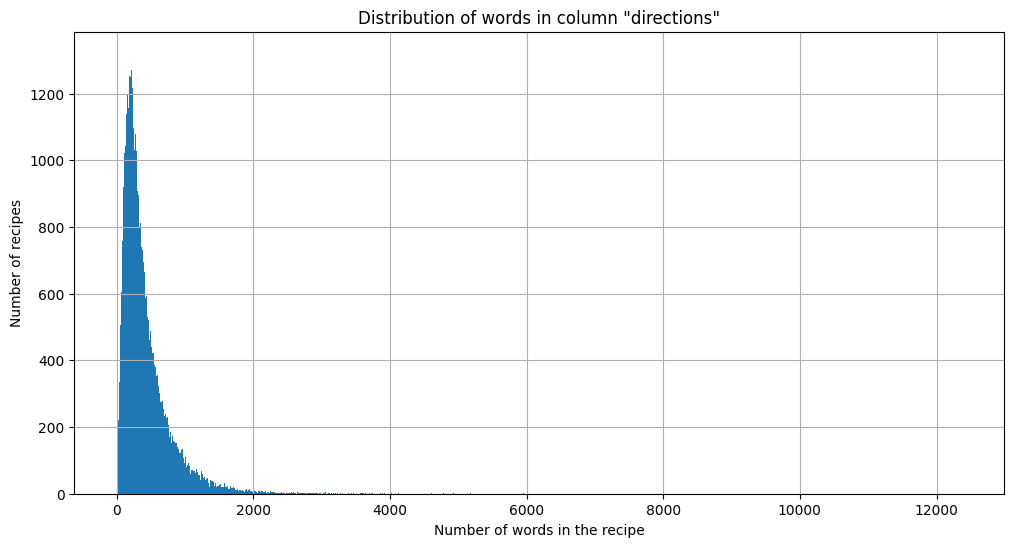

In [ ]:
# Visualize the distribution of the number of words in column "directions" to show how long recipes are (in number of words)
plt.figure(figsize=(12,6))
plt.hist(df['dir_word_count'], bins=max_words, range=(0, max_words))
plt.title('Distribution of words in column \"directions\"')
plt.xlabel('Number of words in the recipe')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [ ]:
# Analyzing recipe word count distribution
word_counts = df['dir_word_count'].dropna()
mean_word_count = word_counts.mean()
median_word_count = word_counts.median()
percentile_90 = word_counts.quantile(0.9)
percentile_95 = word_counts.quantile(0.95)

print(f"Mean word count: {mean_word_count}")
print(f"Median word count: {median_word_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

Mean word count: 419.87529805337533
Median word count: 310.0
90th percentile: 855.0
95th percentile: 1118.0


In [ ]:
# Count recipes with less than upper_threshold words
upper_threshold = 300
count_less_threshold = (word_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} words.")

48.45% of the recipes have at most 300 words.


In [ ]:
# Count recipes with more than lower_threshold words
lower_threshold = 20
count_more_threshold = (word_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} words.")

99.95% of the recipes have at least 20 words.


### Analyze entities distribution
The aim of this section is to analyse the number of elements in the NER column, which contains the number of entities in each recipe, and to provide a distribution, giving a rough measure of the "complexity" of the recipe.

In [ ]:
# Define a new column containing the number of entities of each recipe
ner_column = 'ner_len'
df[ner_column] = df['NER'].apply(lambda x: len(ast.literal_eval(x)))

In [ ]:
# Retrieve the length and index of recipe with highest and lowest NER number
max_ner_len = df[ner_column].max()
min_ner_len = df[ner_column].min()

max_ner_len_idx = df[ner_column].idxmax()
print(f"Recipes have between {min_ner_len} and {max_ner_len} entities.")

print(f"The 'biggest' recipe has {max_ner_len} entities and it is at location {max_ner_len_idx}.")
#print(df['NER'].loc[max_ner_len_idx])

Recipes have between 0 and 402 entities.
The 'biggest' recipe has 402 entities and it is at location 719239.


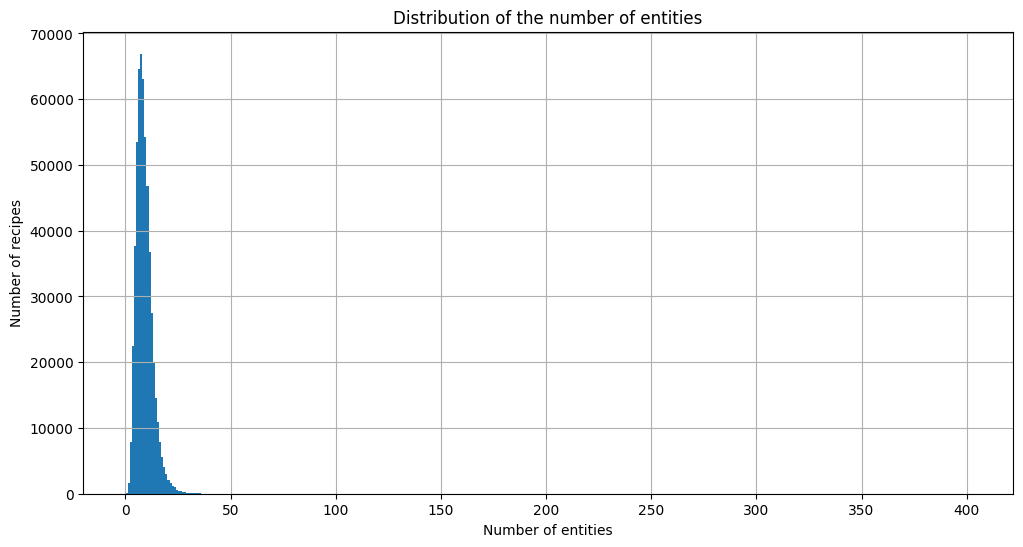

In [ ]:
# Visualize the number of entities in each recipe
plt.figure(figsize=(12,6))
plt.hist(df[ner_column], bins=max_ner_len, range=(0, max_ner_len))
plt.title('Distribution of the number of entities')
plt.xlabel('Number of entities')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [ ]:
# Analyzing recipe NER count distribution
entities_counts = df[ner_column].dropna()
mean_entities_count = entities_counts.mean()
median_entities_count = entities_counts.median()
percentile_90 = entities_counts.quantile(0.9)
percentile_95 = entities_counts.quantile(0.95)

print(f"Mean NER count: {mean_entities_count}")
print(f"Median NER count: {median_entities_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

Mean NER count: 8.482846468000272
Median NER count: 8.0
90th percentile: 13.0
95th percentile: 16.0


In [ ]:
# Count recipes with less than upper_threshold entities
upper_threshold = 25
count_less_threshold = (entities_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} entities.")

99.72% of the recipes have at most 25 entities.


In [ ]:
# Count recipes with more than lower_threshold entities
lower_threshold = 3
count_more_threshold = (entities_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} entities.")

98.27% of the recipes have at least 3 entities.


In [ ]:
# Filter recipes where there are NO NER
zero_NER_recipes = df[df['ner_len'] == 0]

print(zero_NER_recipes[['title', 'NER']])
# Drop recipes where there are no NERs
df = df[df['ner_len'] != 0]

                                                     title NER
1795606                                        Aromatic Fu  []
2099220                                  Roasting Squashes  []
2134230                               Biscuit Pocket Bread  []
1342271                                       Duck Breast   []
1821196                                     Baby Back Ribs  []
...                                                    ...  ..
1337658  Spaghetti With Olives, Dried Chillies And Pang...  []
407311                                        Unfried Pies  []
1383058            Traditional Armenian Dish - Lamb Recipe  []
1735481                                          Asparagus  []
1285166  Cauliflower  Broccoli Dish With Bacon And Che...  []

[128 rows x 2 columns]


It means that the NER process didn't detect any entities for these recipes. This could happen for various reasons, such as:
- The recipe doesn't contain recognizable entities like ingredients, amounts, or special terms.
- The NER process might not be comprehensive enough to detect all relevant entities in the recipe.
- The recipe could be incomplete or malformed in a way that prevents proper entity recognition.

For this reason, we decided to drop these rows.

NB: It may happens that there are NO entries without NER, since we are using a subsample of the original dataset.

# Word2Vec

Training a Word2Vec embedding on the RecipeNLG dataset allows us to capture the semantic relationships between words in ingredients.

Word2Vec learns to represent words as dense vectors, where words with similar meanings are positioned closer together in the vector space. This enables us to explore word similarities, identify common patterns, and improve various natural language processing tasks like recipe recommendation and ingredient analysis.

In [ ]:
# Import useful libraries
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA

In [ ]:
# Convert the 'text' column of the df into a list of strings
w2v_directions = list(df['text'])

# Tokenize each direction, remove stopwords and direction with only 1 word
tokenized_directions = [re.sub('\W', ' ', direction).lower().split() for direction in w2v_directions]
filtered_directions = [[word for word in sublist if word not in stop_words] for sublist in tokenized_directions]
filtered_directions = [direction for direction in filtered_directions if len(direction) > 1]

In [ ]:
# Train the Word2Vec model
w2v_model = Word2Vec(
    sentences=filtered_directions,
    vector_size=50,
    window=10,
    min_count=5
)

### Evaluation
Ever wondered what is a possible vector representation of the word soup?  Me neither!

In [ ]:
term = 'soup'
w2v_model.wv[term]

array([ 4.0647278e+00,  1.7559116e-01,  4.3671951e+00,  3.9502227e+00,
       -4.4002962e-01, -7.0562202e-01, -1.2450949e+00,  1.0900917e+01,
       -5.7735782e+00,  2.0690055e+00,  2.2726400e+00, -3.1491334e+00,
       -8.5098308e-01,  2.4332826e+00,  5.7799087e+00,  3.0633855e+00,
       -4.0411270e-01,  4.3033104e+00, -5.4759377e-01,  4.0405345e+00,
        2.6040916e+00, -3.6019988e+00, -5.6047225e+00, -9.9228024e-01,
       -2.4160583e+00, -1.2929324e+00, -5.6725281e-01, -4.3278637e+00,
        2.7389431e+00,  2.4189241e+00,  5.1059449e-01, -8.6833992e+00,
       -6.1121541e-01,  2.8121800e+00,  3.6854434e+00,  3.3090937e+00,
        2.4508839e+00, -5.0579190e+00, -4.6602077e+00, -6.0003624e+00,
        5.0977612e+00, -6.3325639e+00, -1.3959466e+00, -1.2269708e-03,
        3.4436584e+00, -3.1221619e+00,  5.5601597e+00, -3.8812327e+00,
        9.5960510e-01, -2.1094255e+00], dtype=float32)

Or what are the most similar words to 'chicken' (between the ones in our dataset)

In [ ]:
term = 'chicken'
w2v_model.wv.most_similar(term)

[('breasts', 0.7938339114189148),
 ('thighs', 0.7232164144515991),
 ('drumsticks', 0.6854954361915588),
 ('hen', 0.6629148125648499),
 ('pheasant', 0.6580523252487183),
 ('turkey', 0.6536442637443542),
 ('wings', 0.6422514915466309),
 ('breast', 0.639548122882843),
 ('wing', 0.6363661885261536),
 ('tenders', 0.6358274221420288)]

From 0 to 1, how  similar the words chicken and beef are?

In [ ]:
w2v_model.wv.similarity('chicken', 'beef')

0.46393943

What is to beef what 'breast' is to chicken?

`chicken:breast = beef:?`

In [ ]:
vec = w2v_model.wv['beef'] + w2v_model.wv['breast'] - w2v_model.wv['chicken']
w2v_model.wv.similar_by_vector(vec)

[('sirloin', 0.7210007309913635),
 ('bison', 0.7048829197883606),
 ('beef', 0.7018583416938782),
 ('chuck', 0.681581974029541),
 ('meat', 0.6506745219230652),
 ('corned', 0.6300675868988037),
 ('elk', 0.620155930519104),
 ('caul', 0.6103583574295044),
 ('shank', 0.6011230945587158),
 ('deer', 0.5880143642425537)]

Right now we are working with embedding vectors of 50 dimensions. Unfortunately, the human brain is limited and can visualize only up to three of them. So it's necessary to reduce our vectors' dimensions to this number.

We do so using t-distributed stochastic neighbor embedding (t-SNE). We sample the most frequent 1000 words to allow t-SNE to build a meaningful 3D structure, but we plot only the first 300 to keep the visualization clean and readable.

In [ ]:
# Get the words frequencies
word_freqs = [(word, w2v_model.wv.get_vecattr(word, "count")) for word in w2v_model.wv.key_to_index]

# Sort by frequency in descending order
top_words = sorted(word_freqs, key=lambda x: x[1], reverse=True)

# Select top N most frequent words
top_words = [word for word, _ in top_words[:1000]]
vectors = w2v_model.wv[top_words]

# Apply t-SNE to reduce the 500 high-dimensional vectors to 3D
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(vectors)

x, y, z = np.transpose(tsne_embedding)

# Create a 3D scatter plot (using only the first 300 points for readability)
fig = px.scatter_3d(x=x[:300],y=y[:300],z=z[:300],text=top_words[:300])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

By inspecting the plot we can see that terms belonging to the same semantic area are close.

For example:
- `margarine` and `butter` are close.
- `pork`, `beef` and `meat` are close.
- Numbers like `350`, `375`, `400` are near each other, likely they represents oven temperatures since we can also find `c` close to them.
- `tablespoon`, `teaspoon`, `cup`, `cups` are close.

We try principal component analysis:

In [ ]:
# Get the words frequencies
word_freqs = [(word, w2v_model.wv.get_vecattr(word, "count")) for word in w2v_model.wv.key_to_index]

# Sort by frequency in descending order
top_words = sorted(word_freqs, key=lambda x: x[1], reverse=True)

# Select top N most frequent words
top_words = [word for word, _ in top_words[:1000]]
vectors = w2v_model.wv[top_words]

# Apply PCA to reduce the 500 high-dimensional vectors to 3D
pca = PCA(n_components=3)
pca_embedding = pca.fit_transform(vectors)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}" )
print(f"Total explained variance: {sum(explained_variance_ratio)}")

x, y, z = np.transpose(pca_embedding)

# Create a 3D scatter plot (using only the first 300 points for readability)
fig = px.scatter_3d(x=x[:300],y=y[:300],z=z[:300],text=top_words[:300])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Explained variance ratio: [0.06746511 0.0568028  0.04498309]
Total explained variance: 0.1692509986460209


The 3 dimensions that hold the most informations tent to agglomerate around the values (0,0,0), making pca reductions not suited for visualisation purposes


# Clustering

Now we perform some clustering analysis.



In [ ]:
# Import useful libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud

In [ ]:
# Convert titles to string and apply TF-IDF vectorization (ignoring English stop words)
vectorizer = TfidfVectorizer(stop_words = 'english')
titles = df['title'].astype(str)
X = vectorizer.fit_transform(titles)

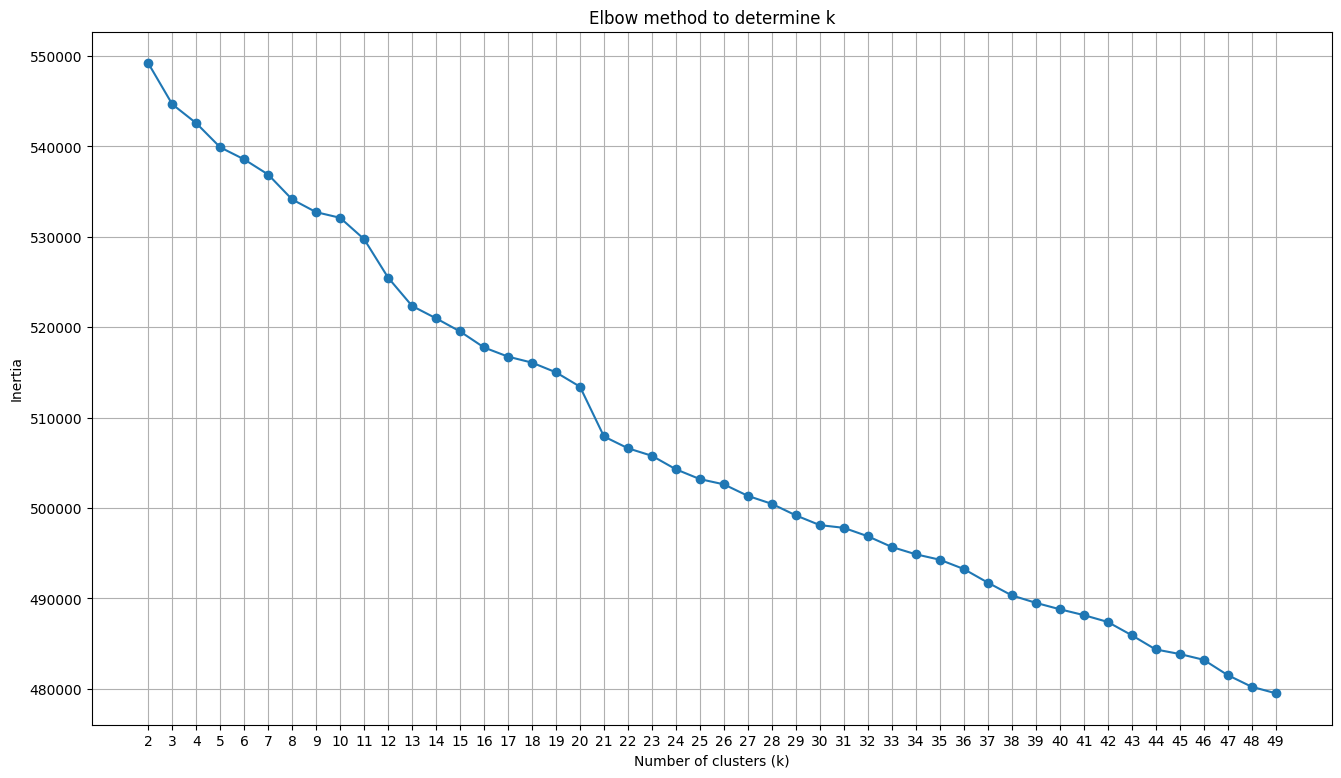

In [ ]:
# Elbow method to determine the optimal number of clusters (k)
inertia = []
k_values = list(range(2, 50))

# Fit KMeans clustering for each k and store inertia
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve to visualize the best k
plt.figure(figsize=(16, 9))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow method to determine k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

It seems that two interesting values for K are 13 and 21, let's try both of them.

In [ ]:
# Apply KMeans with a fixed number of clusters (k = 13)
n_clusters = 13
kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 'auto')
kmeans.fit(X)

# Add clusters to the original dataframe
df['cluster'] = kmeans.labels_

# Print an example of titles grouped by cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))


Cluster 0:
                   Pol Martin Scrambled Eggs Magda
         Crispy Parmesan Polenta With Poached Eggs
Skillet Eggs With Tomatoes, Parmigiano-Reggiano...
         Spiced Coconut Lentils with Peppered Eggs
                            Poached Eggs In Catsup

Cluster 1:
      French Chicken Stew
          Moms Pie Dough 
          Nutty Butty Pie
    Extra Flaky Pie Crust
Puerto Rican Chicken Soup

Cluster 2:
             Pretzel Salad Or Dessert
Crab, Grapefruit And Watercress Salad
                      Vegetable Salad
               Russian Salad Dressing
            Rice And Asparagus Salad 

Cluster 3:
         Barbecued Beef Brisket Recipe
Beef Stew With Potatoes, Spanish Style
              Easy cheese and beef dip
                Deli Corned Beef Bites
              Classic Beef Wellingtons

Cluster 4:
                   Marinated Flank Steak Recipe
                           Chinese Pepper Steak
Tex-Mex Steak Calzones (Sandwich) Pizza Pockets
                          

In [ ]:
# Print number of documents (titles) in each cluster
print('Number of docs in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

Number of docs in: 
Cluster 0: 2573
Cluster 1: 53100
Cluster 2: 33082
Cluster 3: 10419
Cluster 4: 4335
Cluster 5: 11331
Cluster 6: 30683
Cluster 7: 16846
Cluster 8: 14861
Cluster 9: 334053
Cluster 10: 12045
Cluster 11: 18779
Cluster 12: 15551


In [ ]:
# Print the top terms for each cluster (based on TF-IDF centroid weights)
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 0:	['eggs', 'deviled', 'scrambled', 'pickled', 'baked']
Cluster 1:	['chicken', 'pie', 'pecan', 'cream', 'lemon']
Cluster 2:	['salad', 'chicken', 'fruit', 'dressing', 'pasta']
Cluster 3:	['beef', 'stew', 'stroganoff', 'casserole', 'corned']
Cluster 4:	['steak', 'flank', 'pepper', 'swiss', 'grilled']
Cluster 5:	['stuffed', 'tomato', 'peppers', 'soup', 'mushrooms']
Cluster 6:	['cake', 'chocolate', 'pound', 'apple', 'cream']
Cluster 7:	['sauce', 'barbecue', 'spaghetti', 'tomato', 'chicken']
Cluster 8:	['easy', 'shrimp', 'quick', 'dip', 'chicken']
Cluster 9:	['cookies', 'cheese', 'chocolate', 'soup', 'dip']
Cluster 10:	['potato', 'sweet', 'casserole', 'salad', 'soup']
Cluster 11:	['casserole', 'chicken', 'broccoli', 'rice', 'squash']
Cluster 12:	['bread', 'banana', 'zucchini', 'nut', 'pudding']


In [ ]:
# Generate a word cloud for a cluster
def minimal_wordcloud(df_subset, column, cluster_id):
    """
    Generate and display a word cloud for a given cluster.
    """
    text = " ".join(df_subset[column].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Cluster {cluster_id}", fontsize=16)
    plt.show()

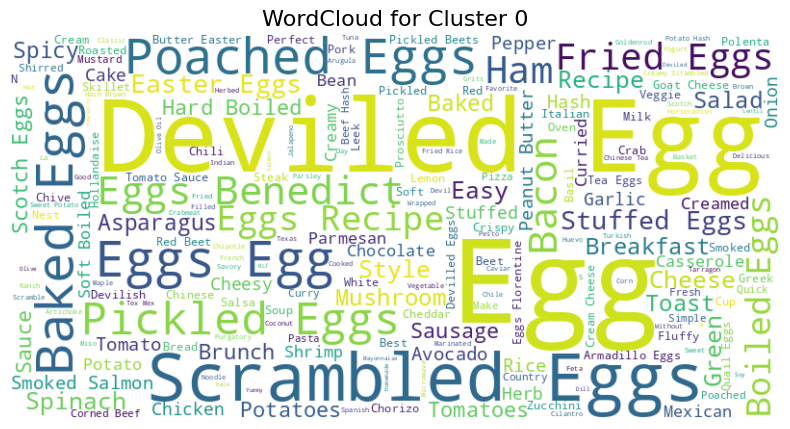

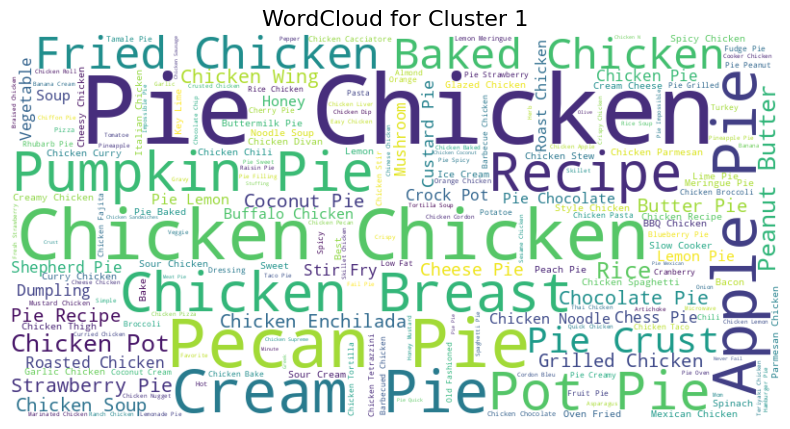

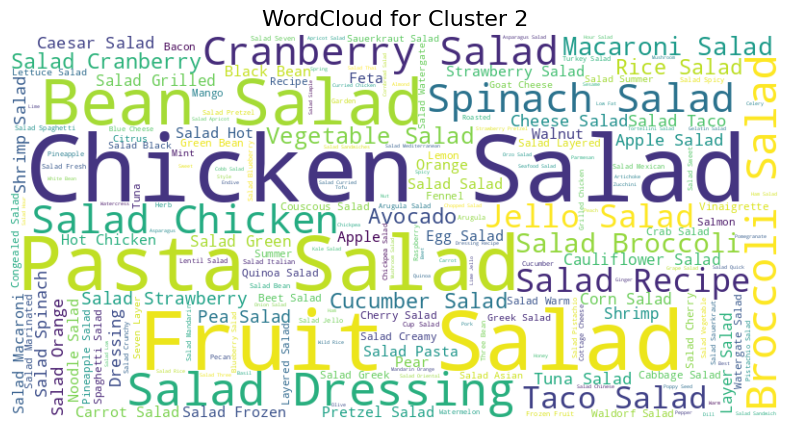

In [ ]:
for cluster_id in range(3):
    cluster_df = df[df['cluster'] == cluster_id]
    minimal_wordcloud(cluster_df, 'title', cluster_id)

In [ ]:
# Repeat clustering with a different number of clusters (k = 21)
n_clusters = 21
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)

df['cluster'] = kmeans.labels_

# Print an example of titles grouped by cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))


Cluster 0:
                   Pol Martin Scrambled Eggs Magda
         Crispy Parmesan Polenta With Poached Eggs
Skillet Eggs With Tomatoes, Parmigiano-Reggiano...
         Spiced Coconut Lentils with Peppered Eggs
                            Poached Eggs In Catsup

Cluster 1:
                 Moms Pie Dough 
                 Nutty Butty Pie
           Extra Flaky Pie Crust
Chicken With Mango And Asparagus
                       Smore Pie

Cluster 2:
                         Sloppy Joe Grilled Cheese
                             Cinnamon Cheese Toast
Balsamic Brussels Sprouts With Feta Cheese And ...
                  Grandma'S Cheese Balls W/Olives 
                                   Cheese Broccoli

Cluster 3:
         Marinated Flank Steak Recipe
                       Glazed Carrots
                         Citrus Syrup
Cranberry And Candied Orange Chutney 
Tau Kua He Ci Medan'S Favourite Food 

Cluster 4:
                               Stuffed Mushrooms
     Simple Stuffed Shells

In [ ]:
# Print number of documents (titles) in each cluster
print('Number of docs in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

Number of docs in: 
Cluster 0: 2531
Cluster 1: 48292
Cluster 2: 16528
Cluster 3: 281323
Cluster 4: 5854
Cluster 5: 10729
Cluster 6: 20671
Cluster 7: 10226
Cluster 8: 8258
Cluster 9: 16404
Cluster 10: 26620
Cluster 11: 16723
Cluster 12: 225
Cluster 13: 9695
Cluster 14: 2972
Cluster 15: 9810
Cluster 16: 14755
Cluster 17: 5348
Cluster 18: 3625
Cluster 19: 15076
Cluster 20: 31993


In [ ]:
# Print the top terms for each cluster (based on TF-IDF centroid weights)
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 0:	['eggs', 'deviled', 'scrambled', 'pickled', 'baked']
Cluster 1:	['chicken', 'pie', 'pecan', 'lemon', 'pot']
Cluster 2:	['cheese', 'ball', 'cream', 'macaroni', 'goat']
Cluster 3:	['recipe', 'chocolate', 'beef', 'rice', 'pork']
Cluster 4:	['stuffed', 'peppers', 'mushrooms', 'shells', 'chicken']
Cluster 5:	['fruit', 'muffins', 'salad', 'bran', 'blueberry']
Cluster 6:	['casserole', 'chicken', 'broccoli', 'potato', 'rice']
Cluster 7:	['dip', 'spinach', 'artichoke', 'cheese', 'hot']
Cluster 8:	['peanut', 'butter', 'cookies', 'chocolate', 'fudge']
Cluster 9:	['soup', 'potato', 'vegetable', 'bean', 'chicken']
Cluster 10:	['cake', 'chocolate', 'pound', 'apple', 'carrot']
Cluster 11:	['sauce', 'barbecue', 'spaghetti', 'tomato', 'chicken']
Cluster 12:	['dollar', 'million', 'pie', 'fudge', 'pound']
Cluster 13:	['cream', 'ice', 'sour', 'pie', 'cake']
Cluster 14:	['french', 'toast', 'onion', 'soup', 'bread']
Cluster 15:	['easy', 'chicken', 'quick', 'pie', 'cake']
Cl

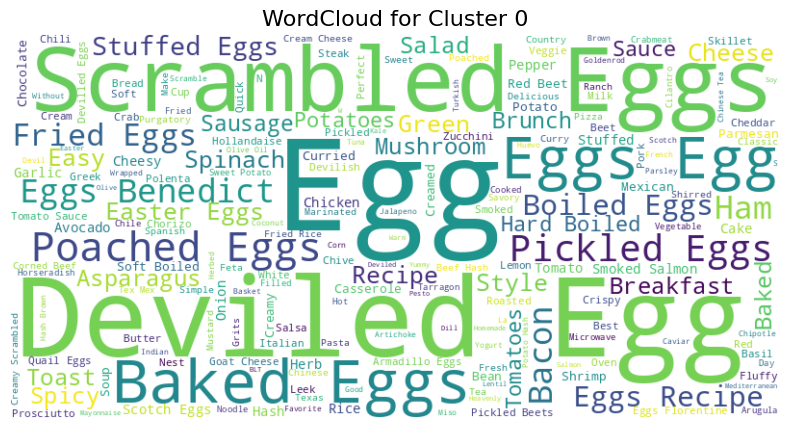

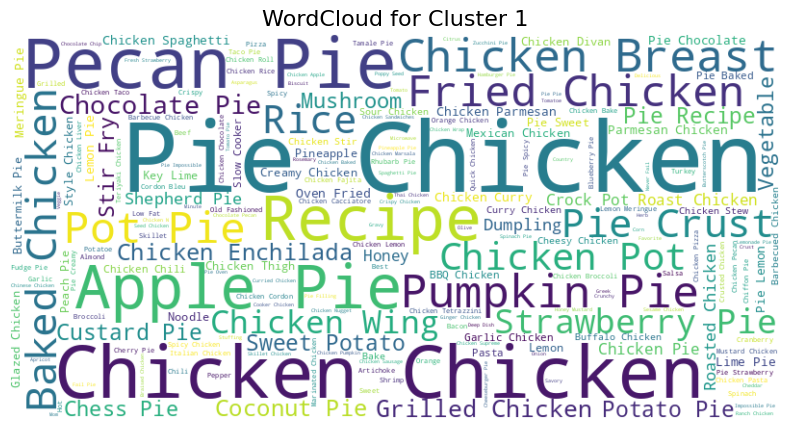

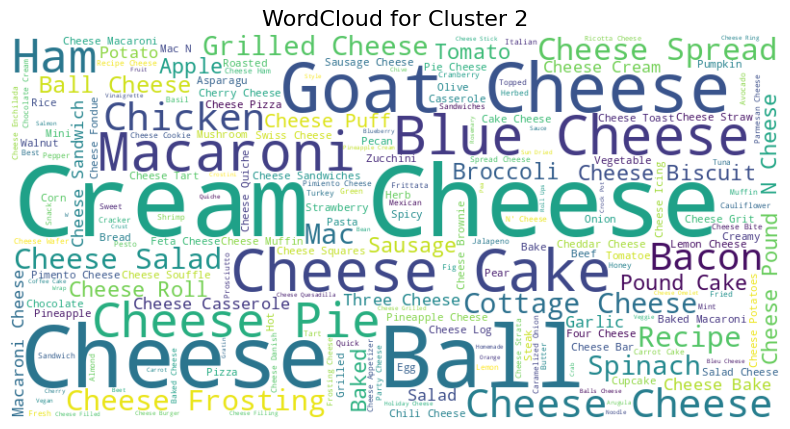

In [ ]:
# Generate a word cloud for 3 cluster
for cluster_id in range(3):
    cluster_df = df[df['cluster'] == cluster_id]
    minimal_wordcloud(cluster_df, 'title', cluster_id)

Both values of k (21 and 13) produce semantically coherent clusters, meaning the top terms within each cluster clearly relate to a common recipe theme or dish type.

For example, cluster 0 (k=21 or k=13): ['eggs', 'deviled', 'scrambled', 'pickled', 'baked'] contains clearly egg-based dishes.

The model with k=21 provides finer granularity, while k=13 offers broader thematic groupings.

### Evaluation

In order to evaluate our clustering we are using only intrinsic method, since we do not have the real labels of the clusters.
Here we will focus on k=21 clusters.

In [ ]:
# Import useful libraries
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD

The Within-Cluster Sum of Squares (WCSS) is an intrinsic evaluation metric that reflects how tightly grouped the samples in each cluster are.

In [ ]:
# Print KMeans inertia (within-cluster sum of squared distances)
print("Intrinsic evaluation measures:")
print("WCSS for K-means", str(kmeans.inertia_))

Intrinsic evaluation measures:
WCSS for K-means 507911.41890223627


In [ ]:
n_clusters = 21
mb_kmeans = MiniBatchKMeans(n_clusters = n_clusters, batch_size = 500, random_state = 2307)
mb_kmeans.fit(X)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(batch_size=500, n_clusters=21, random_state=2307)

In [ ]:
print("Intrinsic evaluation measures:")
print("WCSS for mini-match K-means:", str(mb_kmeans.inertia_))

Intrinsic evaluation measures:
WCSS for mini-match K-means: 509374.4754996095


The WCSS difference is minimal (less than 0.3%), indicating that MiniBatchKMeans provides a very close approximation to standard KMeans.

Now, let's try to visualize clusters.

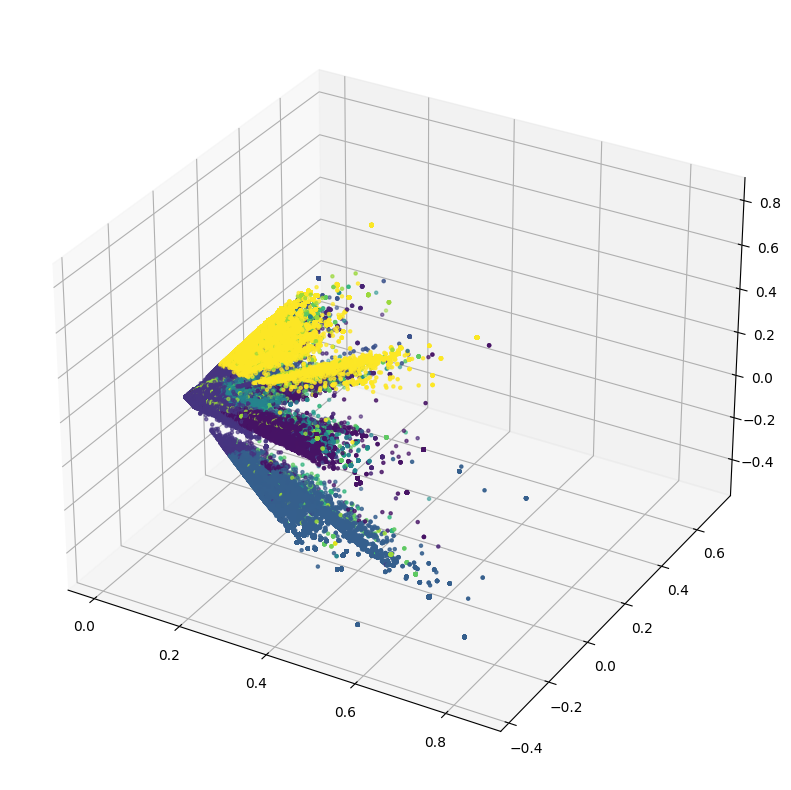

In [ ]:
# Reduce dimensions with Truncated SVD
svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(X)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

# 3D Scatter plot with color-coded clusters
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.')

We have also tried to perform clustering for the NER column, performing the 'elbow method' and plotting the results. However, the plot has not highlighted any points in which improvement in the measure decreases substantially from one time step to the next.

# Training models

In this section we are going to train some models.

In [ ]:
# Import useful libraries
from scipy import sparse
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# LSTM libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

2025-05-20 14:53:44.860072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747752825.213409      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747752825.310982      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Vegan dataset labelling
First of all, we need to create a label indicating wheter the recipe is vegan or not.

To do so, we prompt an LLM to classify a food as vegan or not, given the ingredients. Here we reported the code for clarity, but since it is computationally intensive it is not included in the notebook.

```python
model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Since the dataset is huge, we keep only 20000 entries for the purpose
df = df.sample(n=20000, random_state=42)

# Prepare the prompt
df["ingredients"] = df["ingredients"].astype(str)
system_prompt = """
You are a cooking assistant that must tell if the list of ingredient contains food that are vegan, vegetarian or other.

The output must be in this format:
{
  'food_type': 1 if vegan, 0 otherwise
  'reasoning': reasoning for the answer
}
"""

def is_vegan(ingredients):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": ingredients},
    ]
    outputs = pipe(
        messages,
        max_new_tokens=256,
    )
    response = outputs[0]["generated_text"][-1]['content']
    if "'food_type': 1" in response:
        return 1
    elif "'food_type': 0" in response:
        return 0
    else:
        return None

df["is_vegan"] = df["ingredients"].apply(is_vegan)
df.to_csv("vegan_20k.csv", sep=";", index=False)
```

In [ ]:
# Load the labelled dataset
df_vegan = pd.read_csv("/kaggle/input/vegan-20k/vegan_20k.csv", delimiter=";")

## Binary classification: vegan/non-vegan recipe

We convert the ingredient lists into fixed-length vectors using the trained Word2Vec model.

In [ ]:
# Convert the 'ingredients' column to a list of lists
ingredients = df_vegan['ingredients'].apply(ast.literal_eval)

# Initialize an empty list to store the cleaned data
tokenized_ingredients = []

for ingredient_list in ingredients:
    cleaned_list = []

    for ingredient in ingredient_list:
        # Remove punctuation and convert to lowercase
        ingredient = re.sub(r'[^\w\s]', '', ingredient).lower()
        # Remove numbers and words nearby (e.g., '200g', '5ml', etc.)
        ingredient = re.sub(r'\b\d+(\w+)?\b', '', ingredient)

        # Tokenize
        tokens = ingredient.split()

         # Remove stopwords and single-character tokens
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

        # Add the cleaned tokens to the list
        cleaned_list.extend(tokens)

    # Append the cleaned list to the tokenized_ingredients list
    tokenized_ingredients.append(cleaned_list)

In [ ]:
# Combine each ingredient list back into a single string for TF-IDF processing
corpus = [" ".join(ing) for ing in tokenized_ingredients]

# Compute TF-IDF matrix and dictionary
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_dict = dict(zip(feature_names, tfidf_vectorizer.idf_))

In [ ]:
def vectorize_ingredients_tfidf(ingredient_list, model, tfidf_dict):
    vectors = []
    weights = []

    for word in ingredient_list:
        if word in w2v_model.wv and word in tfidf_dict:
            # Get Word2Vec vector
            word_vec = model.wv[word]

            # Get TF-IDF weight
            weight = tfidf_dict[word]

            # Apply weighting
            vectors.append(word_vec * weight)
            weights.append(weight)

    # Handle cases with no matching words
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)

    # Calculate weighted average
    return np.average(vectors, axis=0, weights=weights)

In [ ]:
# Vectorize all samples using TF-IDF weighted Word2Vec
w2v_tfidf_vectors = np.array([vectorize_ingredients_tfidf(ing, w2v_model, tfidf_dict) for ing in tokenized_ingredients])

In [ ]:
# Count the number of vegan and non-vegan samples
num_vegan = df_vegan[df_vegan['is_vegan'] == 1].shape[0]
num_non_vegan = df_vegan[df_vegan['is_vegan'] == 0].shape[0]

print(f"Number of vegan examples: {num_vegan}")
print(f"Number of non-vegan examples: {num_non_vegan}")

Number of vegan examples: 2176
Number of non-vegan examples: 17824


As we can see, the dataset is higly unbalanced (as expected).

In [ ]:
# 80/20 split for training and testing
y = df_vegan['is_vegan'].values
X_train, X_test, y_train, y_test = train_test_split(w2v_tfidf_vectors, y, test_size=0.2, random_state=42)

# Check class distribution in train and test sets
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Class distribution in training set: [14243  1757]
Class distribution in test set: [3581  419]


### Logistic Regression

In [ ]:
# Logistic Regression
log_model = LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Logistic Regression Accuracy: 0.8033

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88      3581
           1       0.33      0.83      0.47       419

    accuracy                           0.80      4000
   macro avg       0.65      0.82      0.67      4000
weighted avg       0.91      0.80      0.84      4000



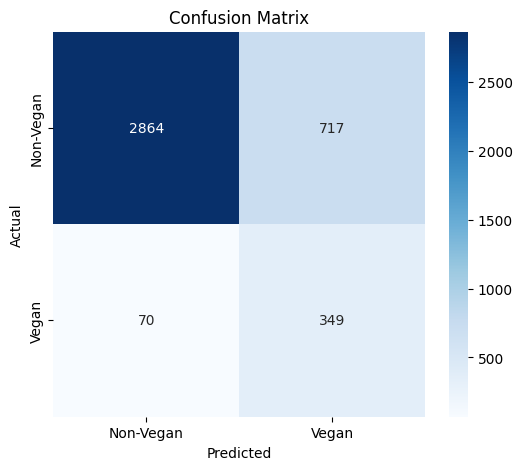

In [ ]:
# Predict on the test set
log_y_pred = log_model.predict(X_test)

# Accuracy
log_acc = accuracy_score(y_test, log_y_pred)
print(f"Logistic Regression Accuracy: {log_acc:.4f}")

# Classification report
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, log_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, log_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Support Vector Machine

In [ ]:
# SVM
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

SVM accuracy: 0.8005

Classification Report:
              precision    recall  f1-score   support

   Non-Vegan       0.98      0.80      0.88      3581
       Vegan       0.33      0.84      0.47       419

    accuracy                           0.80      4000
   macro avg       0.65      0.82      0.67      4000
weighted avg       0.91      0.80      0.83      4000



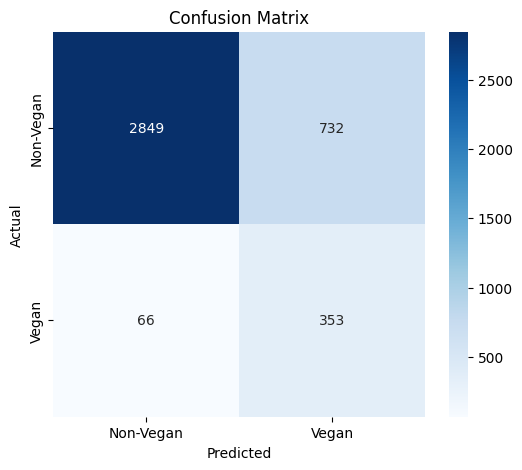

In [ ]:
# Predict on the test set
SVM_y_pred = svm_model.predict(X_test)

# Accuracy
SVM_acc = accuracy_score(y_test, SVM_y_pred)
print(f"SVM accuracy: {SVM_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, SVM_y_pred, target_names=["Non-Vegan", "Vegan"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, SVM_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Although overall accuracy in both logistic regression and SVM is nearly 80%, the models struggle with precision on the vegan class. This indicates many false positives—non-vegan ingredients incorrectly predicted as vegan—which could be problematic depending on the application.

This is a consequence of an highly umbalance dataset. So, we can try to balance the dataset manually.

In [ ]:
# Balance the dataset by undersampling the majority class
y = df_vegan['is_vegan'].values
X_vegan = w2v_tfidf_vectors[y == 1]
X_non_vegan = w2v_tfidf_vectors[y == 0]
y_vegan = y[y == 1]
y_non_vegan = y[y == 0]

# Determine the smaller class size
min_samples = min(len(X_vegan), len(X_non_vegan))

# Subsample both classes to ensure a 50/50 balance
X_vegan_balanced = X_vegan[:min_samples]
y_vegan_balanced = y_vegan[:min_samples]

X_non_vegan_balanced = X_non_vegan[:min_samples]
y_non_vegan_balanced = y_non_vegan[:min_samples]

# Concatenate the balanced dataset
X_balanced = np.vstack((X_vegan_balanced, X_non_vegan_balanced))
y_balanced = np.hstack((y_vegan_balanced, y_non_vegan_balanced))

# Shuffle the dataset
shuffled_indices = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[shuffled_indices]
y_balanced = y_balanced[shuffled_indices]

print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"Class distribution after balancing: {np.bincount(y_balanced)}")

Balanced dataset shape: (4352, 50)
Class distribution after balancing: [2176 2176]


In [ ]:
# 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Check class distribution in train and test sets
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Class distribution in training set: [1732 1749]
Class distribution in test set: [444 427]


Logistic Regression Accuracy: 0.8083

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       444
           1       0.78      0.84      0.81       427

    accuracy                           0.81       871
   macro avg       0.81      0.81      0.81       871
weighted avg       0.81      0.81      0.81       871



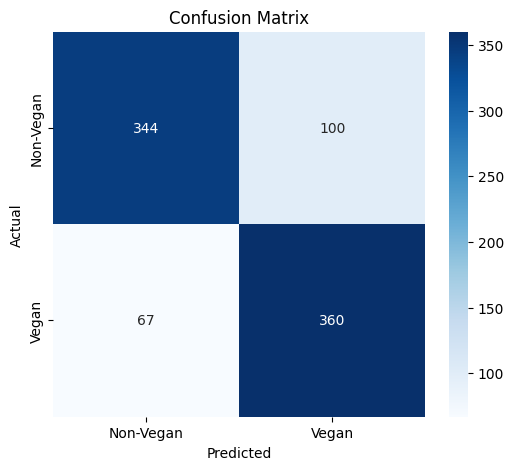

In [ ]:
# Logistic Regression
log_model = LogisticRegression(C=1.0, max_iter=1000)
log_model.fit(X_train, y_train)

# Predict on the test set
log_y_pred = log_model.predict(X_test)

# Accuracy
log_acc = accuracy_score(y_test, log_y_pred)
print(f"Logistic Regression Accuracy: {log_acc:.4f}")

# Classification report
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, log_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, log_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

SVM accuracy: 0.8117

Classification Report:
              precision    recall  f1-score   support

   Non-Vegan       0.85      0.77      0.81       444
       Vegan       0.78      0.86      0.82       427

    accuracy                           0.81       871
   macro avg       0.81      0.81      0.81       871
weighted avg       0.82      0.81      0.81       871



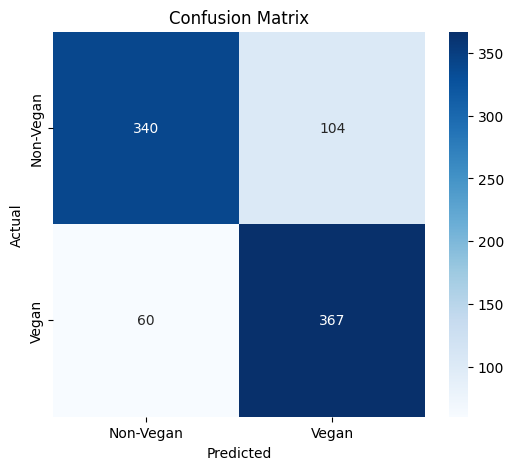

In [ ]:
# SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on the test set
SVM_y_pred = svm_model.predict(X_test)

# Accuracy
SVM_acc = accuracy_score(y_test, SVM_y_pred)
print(f"SVM accuracy: {SVM_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, SVM_y_pred, target_names=["Non-Vegan", "Vegan"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, SVM_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

With a balanced dataset, both models perform good with an overall accuracy of 90%.
However, these results are obtained using undersampling of the majority class to achieve a 50/50 distribution. While this allows fair comparison and reveals the potential of linear models, it does not reflect real-world class imbalance, where vegan ingredients are underrepresented.

### BiLSTM
To move better model the true structure of the dataset, we trained a Bidirectional LSTM. This architecture is better suited to learning complex patterns and dependencies in sequences, particularly under class imbalance.

In [ ]:
# Prepare text sequences from tokenized ingredients
texts = [" ".join(tokens) for tokens in tokenized_ingredients]

# Tokenize and convert to sequences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = max(len(seq) for seq in sequences)
X_seq = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Prepare the dataset
y = df_vegan['is_vegan'].values
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

In [ ]:
# Load GloVe embeddings
glove_path = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"

embedding_dim = 100

# Load GloVe vectors into a dict
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [ ]:
# Prepare embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')

])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.build(input_shape=(None, max_len))
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.

2025-05-20 15:11:51.579649: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 283, 100)            │         848,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 933,009 (3.56 MB)

 Trainable params: 933,009 (3.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 75s 175ms/step - accuracy: 0.7361 - loss: 0.5168 - val_accuracy: 0.8697 - val_loss: 0.2697
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 70s 175ms/step - accuracy: 0.8748 - loss: 0.2920 - val_accuracy: 0.8741 - val_loss: 0.3256
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 70s 174ms/step - accuracy: 0.9086 - loss: 0.2216 - val_accuracy: 0.9069 - val_loss: 0.2217
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 74s 184ms/step - accuracy: 0.9402 - loss: 0.1554 - val_accuracy: 0.9103 - val_loss: 0.2286
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.9484 - loss: 0.1266 - val_accuracy: 0.9212 - val_loss: 0.2331
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 71s 178ms/step - accuracy: 0.9560 - loss: 0.0997 - val_accuracy: 0.9262 - val_loss: 0.2210
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.9712 - loss: 0.0756 - val_accuracy: 0.9297 - val_loss: 0.2569
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 70s 176ms/step - accuracy: 0.9722 - loss: 0

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step
LSTM Model Accuracy: 0.9395

LSTM Model Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      3581
           1       0.68      0.79      0.73       419

    accuracy                           0.94      4000
   macro avg       0.83      0.88      0.85      4000
weighted avg       0.94      0.94      0.94      4000



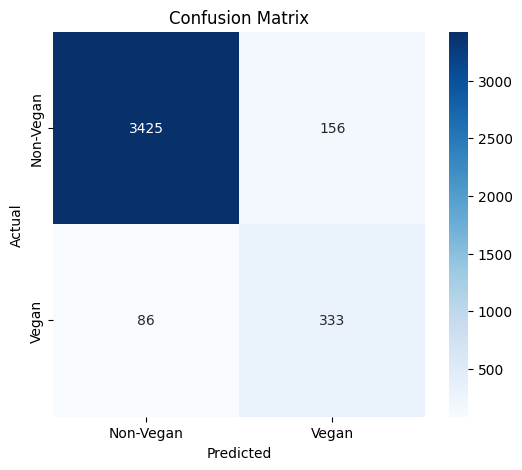

In [ ]:
# Predict on the test set
lstm_y_prob = lstm_model.predict(X_test).flatten()
lstm_y_pred = (lstm_y_prob >= 0.5).astype(int)

# Accuracy
lstm_acc = accuracy_score(y_test, lstm_y_pred)
print(f"LSTM Model Accuracy: {lstm_acc:.4f}")

# Classification report
print("\nLSTM Model Classification Report:\n", classification_report(y_test, lstm_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, lstm_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- The BiLSTM substantially improves recall for the minority class compared to classical models (which were around 80% only under undersampled conditions).
- It maintains very high precision for the majority class while still achieving reasonable precision for the vegan class.